# Predicting Fare of Airline Tickets using Machine Learning

- We perform regression to predict airline fare tickets in India

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly
import cufflinks as cf
import warnings 
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from cufflinks.offline import go_offline
from plotly.offline import plot , iplot , init_notebook_mode , download_plotlyjs
init_notebook_mode(connected=True)
cf.go_offline()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [63]:
# Functions

def change_into_Datetime(col):
    train_df[col] = pd.to_datetime(train_df[col])
    
def extract_hour_min(df , col):
    df[col+"_hour"] = df[col].dt.hour
    df[col+"_minute"] = df[col].dt.minute
    return df

def flight_dep_time(x):
    
    if (x>4) and (x<=8):
        return "Early Morning"
    
    elif (x>8) and (x<=12):
        return "Morning"
    
    elif (x>12) and (x<=16):
        return "Noon"
    
    elif (x>16) and (x<=20):
        return "Evening"
    
    elif (x>20) and (x<=24):
        return "Night"
    
    else:
        return "Late Night"

def preprocess_duration(x):
    
    if 'h' not in x:
        x = '0h' + ' ' + x
    elif 'm' not in x:
        x = x + ' ' +'0m'
        
    return x

def plot(df, col):
    fig , (ax1 , ax2 , ax3) = plt.subplots(3,1)
    
    sns.distplot(df[col] , ax=ax1)
    sns.boxplot(df[col] , ax=ax2)
    sns.distplot(df[col] , ax=ax3 , kde=False)
    
def predict(ml_model):
    model = ml_model.fit(X_train , y_train)
    print('Training score : {}'.format(model.score(X_train , y_train)))
    y_predection = model.predict(X_test)
    print('predictions are : {}'.format(y_predection))
    print('\n')
    r2_score = metrics.r2_score(y_test , y_predection)
    print('r2 score : {}'.format(r2_score))
    print('MAE : {}'.format(metrics.mean_absolute_error(y_test , y_predection)))
    print('MSE : {}'.format(metrics.mean_squared_error(y_test , y_predection)))
    print('RMSE : {}'.format(np.sqrt(metrics.mean_squared_error(y_test , y_predection))))
    sns.distplot(y_test - y_predection)

In [3]:
# Load training data
train_data = pd.read_excel(r"Data_Train.xlsx")
train_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [4]:
# Missing values
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [5]:
# Remove rows with missing values (insignificant to large dataset)
train_data.dropna(inplace=True)

In [6]:
# Confirm no more values are missing
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [7]:
# Memory usage is (accurately) 7.2 MB
train_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 7.2 MB


## Preprocessing

In [8]:
train_df = train_data.copy()

In [9]:
# convert certain columns from object to datetime datatype
for feature in ['Dep_Time', 'Arrival_Time' , 'Date_of_Journey']:
    change_into_Datetime(feature)

In [10]:
# confirm datatypes change
train_df.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [11]:
train_df["Journey_day"] = train_df['Date_of_Journey'].dt.day
train_df["Journey_month"] = train_df['Date_of_Journey'].dt.month
train_df["Journey_year"] = train_df['Date_of_Journey'].dt.year
train_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-03-13 22:20:00,2024-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-03-13 05:50:00,2024-03-13 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2024-03-13 09:25:00,2024-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2024-03-13 18:05:00,2024-03-13 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2024-03-13 16:50:00,2024-03-13 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2024-03-13 19:55:00,2024-03-13 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2024-03-13 20:45:00,2024-03-13 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2024-03-13 08:20:00,2024-03-13 11:20:00,3h,non-stop,No info,7229,27,4,2019
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2024-03-13 11:30:00,2024-03-13 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019


In [12]:
# Extract departure time
extract_hour_min(train_df, 'Dep_Time')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-03-13 22:20:00,2024-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-03-13 05:50:00,2024-03-13 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2024-03-13 09:25:00,2024-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019,9,25
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2024-03-13 18:05:00,2024-03-13 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019,18,5
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2024-03-13 16:50:00,2024-03-13 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019,16,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2024-03-13 19:55:00,2024-03-13 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019,19,55
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2024-03-13 20:45:00,2024-03-13 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019,20,45
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2024-03-13 08:20:00,2024-03-13 11:20:00,3h,non-stop,No info,7229,27,4,2019,8,20
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2024-03-13 11:30:00,2024-03-13 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019,11,30


In [13]:
# Extract arrival time
extract_hour_min(train_df, 'Arrival_Time')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-03-13 22:20:00,2024-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-03-13 05:50:00,2024-03-13 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2024-03-13 09:25:00,2024-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2024-03-13 18:05:00,2024-03-13 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2024-03-13 16:50:00,2024-03-13 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2024-03-13 19:55:00,2024-03-13 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019,19,55,22,25
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2024-03-13 20:45:00,2024-03-13 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019,20,45,23,20
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2024-03-13 08:20:00,2024-03-13 11:20:00,3h,non-stop,No info,7229,27,4,2019,8,20,11,20
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2024-03-13 11:30:00,2024-03-13 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019,11,30,14,10


In [14]:
## After extracting derived attributes, drop both features
cols_to_drop = ['Arrival_Time' , "Dep_Time"]

train_df.drop(cols_to_drop , axis=1 , inplace=True )

<Axes: >

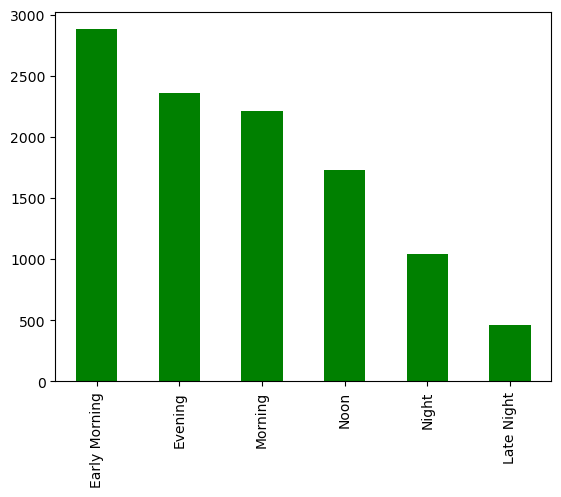

In [15]:
# Classifying the flight departure into time-period categories
# Static plot
train_df['Dep_Time_hour'].apply(flight_dep_time).value_counts().plot(kind="bar" , color="g")

In [16]:
# (Interactive) Plotting flight departure categories
train_df['Dep_Time_hour'].apply(flight_dep_time).value_counts().iplot(kind="bar")

In [17]:
# 'Duration' feature engineering
train_df['Duration'] = train_df['Duration'].apply(preprocess_duration)
train_df['Duration']

0        2h 50m
1        7h 25m
2        19h 0m
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680     3h 0m
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10682, dtype: object

In [18]:
train_df['Duration_hours'] = train_df['Duration'].apply(lambda x : int(x.split(' ')[0][0:-1]))
train_df['Duration_mins'] = train_df['Duration'].apply(lambda x : int(x.split(' ')[1][0:-1]))
train_df

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_mins
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2h 30m,non-stop,No info,4107,4,9,2019,19,55,22,25,2,30
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2h 35m,non-stop,No info,4145,27,4,2019,20,45,23,20,2,35
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,3h 0m,non-stop,No info,7229,27,4,2019,8,20,11,20,3,0
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2h 40m,non-stop,No info,12648,3,1,2019,11,30,14,10,2,40


In [19]:
train_df["Duration_hour"] = pd.to_timedelta(train_df["Duration"]).dt.components.hours
train_df["Duration_minute"] = pd.to_timedelta(train_df["Duration"]).dt.components.minutes

In [20]:
# Convert duration into total minutes
train_df['Duration_total_mins'] = train_df['Duration'].str.replace('h' ,"*60").str.replace(' ' , '+').str.replace('m' , "*1").apply(eval)
train_df['Duration_total_mins']

0         170
1         445
2        1140
3         325
4         285
         ... 
10678     150
10679     155
10680     180
10681     160
10682     500
Name: Duration_total_mins, Length: 10682, dtype: int64

<Axes: xlabel='Duration_total_mins', ylabel='Price'>

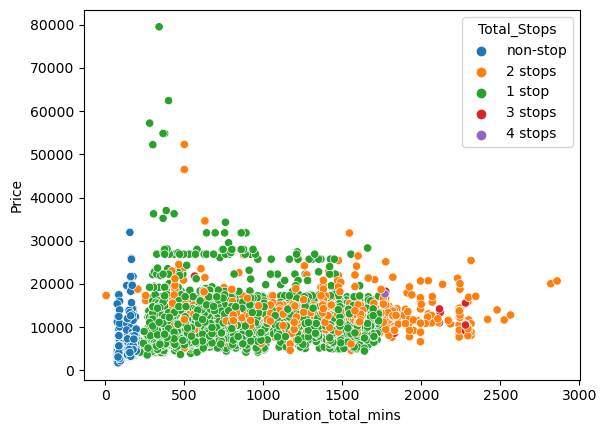

In [21]:
sns.scatterplot(x="Duration_total_mins" , y="Price" , hue="Total_Stops", data=train_df)

- As expected, the duration generally increases when a flight has more stops.
- Most flights are below 30,000 rupees (approximately $360). A few outliers are much higher due to being either 1 or 2 stops, but with a relatively short flight duration (of less than 500 minutes - i.e. just over 8 hours including layovers).

In [22]:
train_df[train_df['Airline']=='Jet Airways'].groupby('Route').size().sort_values(ascending=False)

Route
CCU → BOM → BLR          930
DEL → BOM → COK          875
BLR → BOM → DEL          385
BLR → DEL                382
CCU → DEL → BLR          300
BOM → HYD                207
DEL → JAI → BOM → COK    207
DEL → AMD → BOM → COK    141
DEL → IDR → BOM → COK     86
DEL → NAG → BOM → COK     61
DEL → ATQ → BOM → COK     38
DEL → COK                 34
DEL → BHO → BOM → COK     29
DEL → BDQ → BOM → COK     28
DEL → LKO → BOM → COK     25
DEL → JDH → BOM → COK     23
CCU → GAU → BLR           22
DEL → MAA → BOM → COK     16
DEL → IXC → BOM → COK     13
BLR → MAA → DEL           10
BLR → BDQ → DEL            8
DEL → UDR → BOM → COK      7
BOM → DEL → HYD            5
CCU → BOM → PNQ → BLR      4
BLR → BOM → JDH → DEL      3
DEL → DED → BOM → COK      2
BOM → BDQ → DEL → HYD      2
DEL → CCU → BOM → COK      1
BOM → VNS → DEL → HYD      1
BOM → UDR → DEL → HYD      1
BOM → JDH → DEL → HYD      1
BOM → IDR → DEL → HYD      1
BOM → DED → DEL → HYD      1
dtype: int64

 - The routes CCU → BOM → BLR and DEL → BOM → COK are by far the most used with Jet Airways.

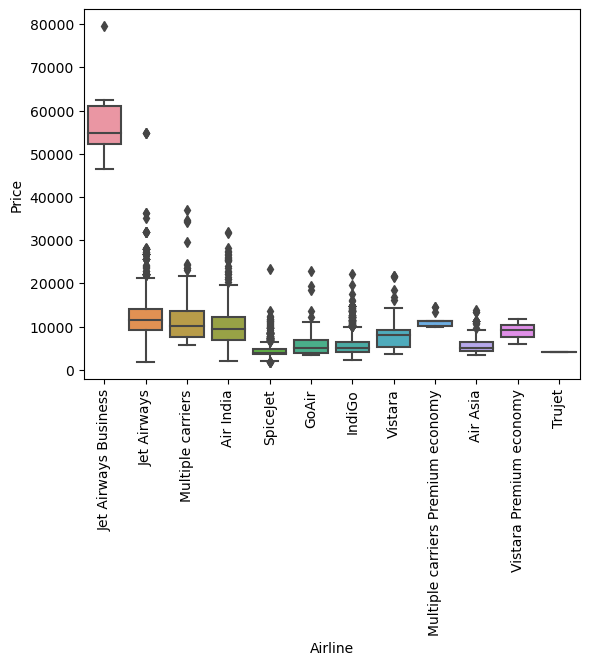

In [23]:
sns.boxplot(y='Price' , x='Airline' , data=train_df.sort_values('Price' , ascending=False))
plt.xticks(rotation="vertical")
plt.show()

- Jet Airways Business appears to have much higher prices compared all the other airlines (whose median flight prices are similar)

In [24]:
cat_col = [col for col in train_df.columns if train_df[col].dtype=="object"]
num_col = [col for col in train_df.columns if train_df[col].dtype!="object"]

In [25]:
cat_col

['Airline',
 'Source',
 'Destination',
 'Route',
 'Duration',
 'Total_Stops',
 'Additional_Info']

In [26]:
train_df['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [27]:
# Manually one-hot-encode
for sub_category in train_df['Source'].unique():
    train_df['Source_'+sub_category] = train_df['Source'].apply(lambda x : 1 if x==sub_category else 0)

In [28]:
train_df

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,...,Duration_hours,Duration_mins,Duration_hour,Duration_minute,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,...,2,50,2,50,170,1,0,0,0,0
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,...,7,25,7,25,445,0,1,0,0,0
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,...,19,0,19,0,1140,0,0,1,0,0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,...,5,25,5,25,325,0,1,0,0,0
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,...,4,45,4,45,285,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2h 30m,non-stop,No info,4107,4,...,2,30,2,30,150,0,1,0,0,0
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2h 35m,non-stop,No info,4145,27,...,2,35,2,35,155,0,1,0,0,0
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,3h 0m,non-stop,No info,7229,27,...,3,0,3,0,180,1,0,0,0,0
10681,Vistara,2019-01-03,Banglore,New Delhi,BLR → DEL,2h 40m,non-stop,No info,12648,3,...,2,40,2,40,160,1,0,0,0,0


In [29]:
train_df.groupby(['Airline'])['Price'].mean().sort_values()

Airline
Trujet                                4140.000000
SpiceJet                              4338.284841
Air Asia                              5590.260188
IndiGo                                5673.682903
GoAir                                 5861.056701
Vistara                               7796.348643
Vistara Premium economy               8962.333333
Air India                             9612.427756
Multiple carriers                    10902.678094
Multiple carriers Premium economy    11418.846154
Jet Airways                          11643.923357
Jet Airways Business                 58358.666667
Name: Price, dtype: float64

In [30]:
# Target-guided ordinal encoding to avoid creating too many airline features
airlines = train_df.groupby(['Airline'])['Price'].mean().sort_values().index
dict_airlines = {key:index for index , key in enumerate(airlines , 0)}
dict_airlines

{'Trujet': 0,
 'SpiceJet': 1,
 'Air Asia': 2,
 'IndiGo': 3,
 'GoAir': 4,
 'Vistara': 5,
 'Vistara Premium economy': 6,
 'Air India': 7,
 'Multiple carriers': 8,
 'Multiple carriers Premium economy': 9,
 'Jet Airways': 10,
 'Jet Airways Business': 11}

In [31]:
train_df['Airline'] = train_df['Airline'].map(dict_airlines)

In [32]:
# New Delhi and Delhi share are airport
train_df['Destination'].unique()
train_df['Destination'].replace('New Delhi' , 'Delhi' , inplace=True)

In [33]:
# Target-guided ordinal encoding to avoid creating too many destination features
dest = train_df.groupby(['Destination'])['Price'].mean().sort_values().index
dict_dest = {key:index for index , key in enumerate(dest , 0)}
dict_dest

{'Kolkata': 0, 'Hyderabad': 1, 'Delhi': 2, 'Banglore': 3, 'Cochin': 4}

In [34]:
train_df['Destination'] = train_df['Destination'].map(dict_dest)

In [35]:
# Ordinal encoding for number of stops
train_df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [36]:
stop = {'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
train_df['Total_Stops'] = train_df['Total_Stops'].map(stop)

In [37]:
# Delete irrelevant features
train_df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Duration', 'Total_Stops', 'Additional_Info', 'Price', 'Journey_day',
       'Journey_month', 'Journey_year', 'Dep_Time_hour', 'Dep_Time_minute',
       'Arrival_Time_hour', 'Arrival_Time_minute', 'Duration_hours',
       'Duration_mins', 'Duration_hour', 'Duration_minute',
       'Duration_total_mins', 'Source_Banglore', 'Source_Kolkata',
       'Source_Delhi', 'Source_Chennai', 'Source_Mumbai'],
      dtype='object')

In [38]:
# Additional_Info contains almost 80% no_info, so we drop this column
train_df['Additional_Info'].value_counts()/len(train_df)*100

No info                         78.112713
In-flight meal not included     18.554578
No check-in baggage included     2.995694
1 Long layover                   0.177869
Change airports                  0.065531
Business class                   0.037446
No Info                          0.028085
1 Short layover                  0.009362
Red-eye flight                   0.009362
2 Long layover                   0.009362
Name: Additional_Info, dtype: float64

In [39]:
train_df['Journey_year'].unique()

array([2019])

In [40]:
# drop Date_of_Journey as well since we have already extracted "Journey_hour" , "Journey_month" , Journey_day"
# drop Duration_total_mins as we have already extracted "Duration_hours" & "Duration_mins"
# drop "Source" feature as well as we have already perform feature encoding on this Feature 
# drop Journey_year as well , as it has constant values throughtout dataframe which is 2019
train_df.drop(columns=['Date_of_Journey' , 'Additional_Info' , 'Duration_total_mins' , 'Source' , 'Journey_year'] , axis=1 , inplace=True)

In [41]:
# drop Route since it is directly related to Total stops - doesn't make sense while building ML model
train_df.drop(columns=['Route'] , axis=1 , inplace=True)

In [42]:
## drop "Duration" feature as we have extracted "Duration hour" & "Duration Minute"
train_df.drop(columns=['Duration'] , axis=1 , inplace=True)

## Outlier Detection
- To avoid human errors caused by incorrect data collection/recording/entry
- Also avoid using faulty measurement instruments

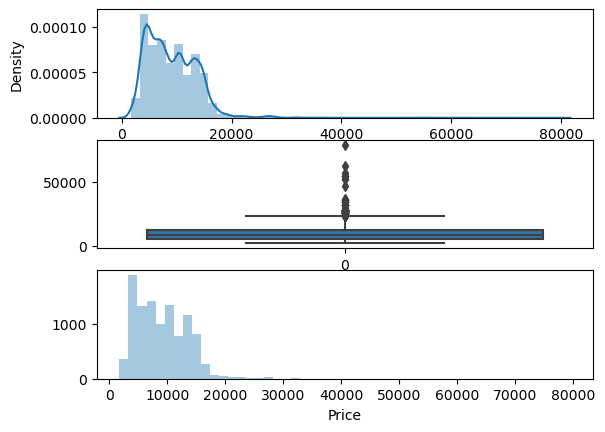

In [43]:
plot(train_df , 'Price')

In [44]:
# Prices within one standard deviation of the mean
q1 = train_df['Price'].quantile(0.25)
q3 = train_df['Price'].quantile(0.75)

iqr = q3 - q1

maximum = q3 + 1.5*iqr
minimum = q1 - 1.5*iqr

In [45]:
# Lower bound of the right tail of price outliers
print(maximum)

23017.0


In [46]:
# pper bound of the left tail of price outliers (not relevant in this context)
print(minimum)

-5367.0


In [47]:
# number of outliers
len([price for price in train_df['Price'] if price> maximum or price<minimum])

94

In [48]:
# deal with outliers by replacing prices greater that 35K with the median
train_df['Price'] = np.where(train_df['Price']>=35000 , train_df['Price'].median() , train_df['Price'])

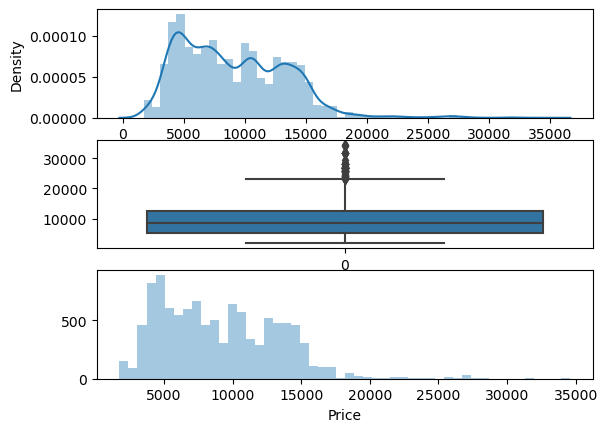

In [49]:
# updated distribution and boxplots
plot(train_df , 'Price')

# Feature Selection
- Only select feature that are relevant to the target variable

In [50]:
# Detect dependance between variable
X = train_df.drop(['Price'] , axis=1)
y = train_df['Price']
imp = mutual_info_regression(X,y)

In [51]:
imp_df = pd.DataFrame(imp , index=X.columns)
imp_df.columns = ['importance']
imp_df

,importance
Airline,0.978614
Destination,1.006686
Total_Stops,0.790188
Journey_day,0.200350
Journey_month,0.240666
Dep_Time_hour,0.342675
Dep_Time_minute,0.260108
Arrival_Time_hour,0.407624
Arrival_Time_minute,0.346631
Duration_hours,0.471114


In [52]:
imp_df.sort_values(by='importance' , ascending=False)

,importance
Destination,1.006686
Airline,0.978614
Total_Stops,0.790188
Source_Delhi,0.518125
Duration_hours,0.471114
Source_Kolkata,0.451707
Duration_hour,0.416182
Arrival_Time_hour,0.407624
Source_Banglore,0.392196
Arrival_Time_minute,0.346631


## Build Machine Learning Model

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
ml_model = RandomForestRegressor()

In [55]:
ml_model.fit(X_train , y_train)

RandomForestRegressor()

In [56]:
y_pred = ml_model.predict(X_test)

In [57]:
metrics.r2_score(y_test , y_pred)

0.80609536185677

In [59]:
# store data
file = open(r'rf_random.pkl' , 'wb')
pickle.dump(ml_model , file)

In [61]:
model = open(r'rf_random.pkl' , 'rb')
forest = pickle.load(model)
y_pred2 = forest.predict(X_test)
metrics.r2_score(y_test , y_pred2)

0.80609536185677

## ML pipeline automation

Training score : 0.9512656505784984
predictions are : [16759.22  6308.53  8698.45 ...  3554.19  6368.09  7090.57]


r2 score : 0.8068500918572051
MAE : 1189.5628997348902
MSE : 3760165.0871385355
RMSE : 1939.1145110948285


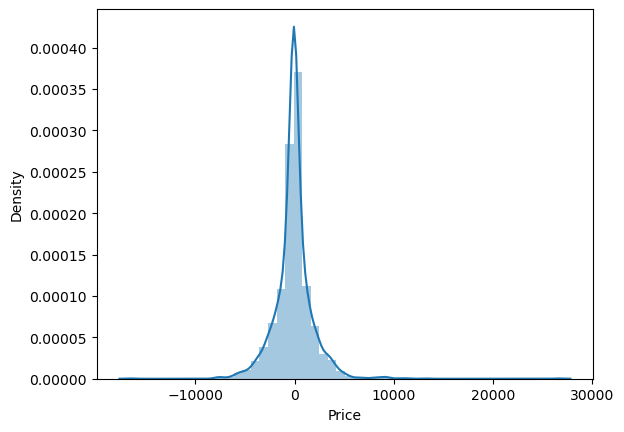

In [64]:
# random forest evaluation metrics
predict(RandomForestRegressor())

Training score : 0.9664600803077188
predictions are : [16840.  6976.  8610. ...  3419.  5797.  6818.]


r2 score : 0.6902471239563961
MAE : 1380.247223262199
MSE : 6030144.986032489
RMSE : 2455.6353528226637


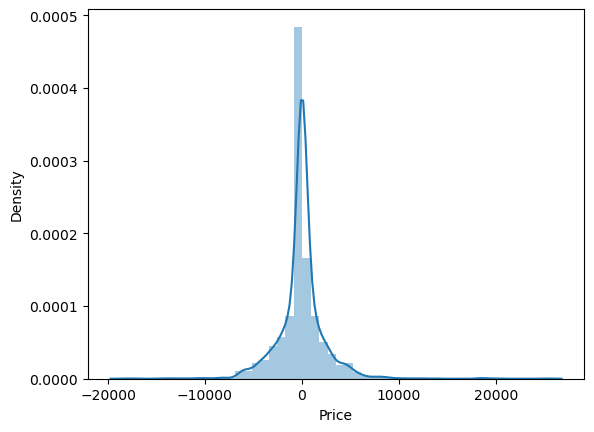

In [65]:
# decision tree evaluation metrics
predict(DecisionTreeRegressor())

## Hypertuning

In [66]:
# initialise estimator
reg_rf = RandomForestRegressor()

In [67]:
np.linspace(start =100 , stop=1200 , num=6)

array([ 100.,  320.,  540.,  760.,  980., 1200.])

In [68]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start =100 , stop=1200 , num=6)]

# Number of features to consider at every split
max_features = ["auto", "sqrt"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start =5 , stop=30 , num=4)]

# Minimum number of samples required to split a node
min_samples_split = [5,10,15,100]

In [69]:
# Create hyper-parameter space
random_grid = {
    'n_estimators' : n_estimators , 
    'max_features' : max_features , 
    'max_depth' : max_depth , 
    'min_samples_split' : min_samples_split
}

In [70]:
# Using 3-fold cross validation
rf_random = RandomizedSearchCV(estimator=reg_rf , param_distributions=random_grid , cv=3 , n_jobs=-1 , verbose=2)

In [71]:
rf_random.fit(X_train , y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy versio

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [72]:
rf_random.best_params_

{'n_estimators': 980,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 13}

In [73]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=13, max_features='auto', min_samples_split=5,
                      n_estimators=980)

In [74]:
rf_random.best_score_

0.8196774369771066